In [1]:
import datetime
import numpy

from scipy.optimize import minimize

from ion_populations import single_ion_population_mass
from coordinates_system_transformation import spherical_to_cartesian, cartesian_to_spherical
from magnetic_field_functions import read_b_model
from longitude_functions import objective_function_rho_0_from_delta_longitude, objective_function_zlimN_from_longitude, delta_longitude_calculation, longitude_MAW_TEB_calculation
from density import rho_z
from alfven_velocity import v_alfven_calculation
from Current_Sheet_values_functions import density_and_scale_height_of_CS_calculation




# First method:
1° Reading of $x_i$, $y_i$, $z_i$, $|B_i|$ values along the magnetic field line instantaneously connected to the moon (based on JRM33+KK2005). With i the index of each point along this field line. Transformed the coordinate in the proper referentiel, so that the CS is properly aligned with z = 0. It can be choosen if the current layer is aligned with the centrifugal, jovicentric or magnetic equator.

2° Determining of $ρ_i$ along the field line, using the equation $ρ_i =ρ_0 * exp^{ - \sqrt{\frac{(r_i - r_0)^2 + z_i^2}{H} }}$ for a given $H$ and $ρ_0$. 

3° Determining of $v_{i}^{Alfvén}$ from these values of $ρ_i$ and $B_i$

4° Determining of travel time $t_{TEB}$ and $t_{MAW}$ --> determination of $\lambda_{TEB}$ and $\lambda_{MAW}$ --> determination of $\Delta \lambda$

5° Repeating steps 2° to 4° with different values of $\rho_0$ to minimise $|\Delta \lambda - \Delta \lambda_{observed}|$.

6° Repeating Step 5° for different values of $H$ to minimise $|\lambda_{TEB} - \lambda_\mathrm{TEB observed}|$ and $|\lambda_{MAW} - \lambda_\mathrm{MAW observed}|$.


In [2]:
R_J = 71492e3 # m

file_mag_model_north = "/Users/clouis/Documents/Etudes/Juno_moon_emissions/Callisto/PJ22_2019_09_12/Bmodel/Callisto_B_line_N_v2.txt"
file_mag_model_south = "/Users/clouis/Documents/Etudes/Juno_moon_emissions/Callisto/PJ22_2019_09_12/Bmodel/Callisto_B_line_S_v2.txt"

(r_N, theta_N, phi_N, B_total_N) = read_b_model(file_mag_model_north)
(r_S, theta_S, phi_S, B_total_S) = read_b_model(file_mag_model_south)

r_N = r_N*R_J
r_S = r_S*R_J

#B is in nT --> T
B_total_N = B_total_N*1e-9 # T: kg/(A.s^2)
B_total_S = B_total_S*1e-9 # T: kg/(A.s^2)


rotation_rate_callisto =  0.0098 # °/s

lambda_observed_MAW = 297.7
lambda_observed_TEB = 303.05


m_e = 9.109e-31 # kg
keV = 1.602e-16 # J == kg.m^2/s^2

rho_0_volumetric_first_guess = 4000/1e-6*m_e #kg/m^3
r_0 = 26.33*R_J

no_CS_calculation = False

E_array = numpy.array([1])*keV
z_lim_N_array = numpy.array([0.74, 0.96, 1.03, 1.63, 2.22, 2.8, 3.36])*R_J # correspond to specific H values [0.75, 0.94, 1, 1.5, 2., 2.5, 3.0] for CS aligned with centrifugal equator
#z_lim_N_array = numpy.array(z_lim_N in [0.15,0.46, 0.74, 1.115, 1.77, 2.4, 3.01]) # correspond to specific H values [0.75, 1, 1.21, 1.5, 2., 2.5, 3.0] for CS aligned with Mag equator

(H_array, # Height Scale in Rp
            rho_0_array, #total mass density in the center of the PS in kg.cm^-3
            n_0_ions_array, # ions density in the PS cm^-3
            n_0_electrons, # electrons density in the PS cm^-3
            longitude_TEB, # TEB longitude
            longitude_MAW, # MAW longitude
            n_at_Moon_ions, # ions density at the moon orbit cm^-3
            n_at_Moon_electrons, # electrons density at the moon orbit cm^-3 
            units
            ) =  density_and_scale_height_of_CS_calculation(r_N, theta_N, phi_N, B_total_N,
                                   r_S, theta_S, phi_S, B_total_S,
                                   E_array,
                                   z_lim_N_array, r_0,
                                   lambda_observed_MAW,
                                   lambda_observed_TEB,
                                   rho_0_volumetric_first_guess = rho_0_volumetric_first_guess,
                                   rotation_rate =  0.0098,
                                   jovicentric_equator = False,
                                   centrifugal_equator = True,
                                   magnetic_equator = False,
                                   verbose = True,
                                   disk = False,
                                   torus = True)
    


(1.88E+07 m/s (E = 1.00 keV)
H: 0.75
ρ_0_optimized: 6.79E-27 kg/cm^3
ρ0: 6.79E-27 kg.cm^-3
n_0_ions: 1.75E-01 cm^-3
n_0_electrons: 2.80E-01 cm^-3
λ (TEB) from UV measurement: 303.05
λ (MAW) from UV measurement: 297.70
Δλ observed: 5.35°
λ TEB: 301.94°, 
λ MAW: 296.59°
Δλ: 5.35°
n_ions @ Moon: 9.96E-02 cm^-3
n_electrons @ Moon: 1.59E-01 cm^-3

 
 

(1.88E+07 m/s (E = 1.00 keV)
H: 0.94
ρ_0_optimized: 6.37E-27 kg/cm^3
ρ0: 6.37E-27 kg.cm^-3
n_0_ions: 1.65E-01 cm^-3
n_0_electrons: 2.62E-01 cm^-3
λ (TEB) from UV measurement: 303.05
λ (MAW) from UV measurement: 297.70
Δλ observed: 5.35°
λ TEB: 300.79°, 
λ MAW: 295.44°
Δλ: 5.35°
n_ions @ Moon: 1.05E-01 cm^-3
n_electrons @ Moon: 1.67E-01 cm^-3

 
 

(1.88E+07 m/s (E = 1.00 keV)
H: 1.00
ρ_0_optimized: 6.29E-27 kg/cm^3
ρ0: 6.29E-27 kg.cm^-3
n_0_ions: 1.62E-01 cm^-3
n_0_electrons: 2.59E-01 cm^-3
λ (TEB) from UV measurement: 303.05
λ (MAW) from UV measurement: 297.70
Δλ observed: 5.35°
λ TEB: 300.46°, 
λ MAW: 295.11°
Δλ: 5.35°
n_ions @ Moon: 1.06E-

# Second method:
1° Reading of $x_i$, $y_i$, $z_i$, $|B_i|$ values along the magnetic field line instantaneously connected to the moon (based on JRM33+KK2005). With i the index of each point along this field line. Transformed the coordinate in the proper referentiel, so that the CS is properly aligned with z = 0. It can be choosen if the current layer is aligned with the centrifugal, jovicentric or magnetic equator.

2° Determining of $ρ_i$ along the field line, using the equation $ρ_i =ρ_0 * exp^{ - \sqrt{\frac{(r_i - r_0)^2 + z_i^2}{H} }}$ for a given $H$ and $ρ_0$. 

3° Determining of $v_{i}^{Alfvén}$ from these values of $ρ_i$ and $B_i$

4° Determining of travel time $t_{TEB}$ and $t_{MAW}$ --> determination of $\lambda_{TEB}$ and $\lambda_{MAW}$ --> determination of $\Delta \lambda$

5° Repeating steps 2° to 4° with different values of $\rho_0$ and $H$ to minimise both $|\Delta \lambda - \Delta \lambda_{observed}|$ and $|\lambda_{TEB} - \lambda_\mathrm{TEB observed}|$ or $|\lambda_{MAW} - \lambda_\mathrm{MAW observed}|$.




In [2]:
from scipy.optimize import minimize
import numpy as np

c = 3e8 #m/s
# Define the nested function for optimizing rho_0 given a fixed z_lim_N
def optimize_rho_0(z_lim_N, r_0, H, rho_0_volumetric_first_guess,
                   x_N, y_N, z_N, B_N,
                   x_S, y_S, z_S, B_S,
                   mask_CS_N, mask_CS_S,
                   v, rotation_rate_callisto, 
                   delta_longitude_observed, disk=False, torus=False):

    # Define the inner objective function for rho_0 minimization
    def objective_function_rho_0_from_delta_longitude(rho_0, r_0, H,
                                       x_N, y_N, z_N, 
                                       x_S, y_S, z_S,
                                       B_N, B_S,
                                       mask_CS_N, mask_CS_S,
                                       v, rotation_rate_callisto, delta_longitude_observed,
                                       disk = False, torus = False):
                                       
        #if numpy.any(mask_CS_N):
        rho_CS_N = rho_z(x_N[mask_CS_N], y_N[mask_CS_N], z_N[mask_CS_N], r_0, H, rho_0, disk=disk, torus = torus)
        rho_CS_N_volumetric = rho_CS_N
        v_A_N = v_alfven_calculation(B_N[mask_CS_N], rho_CS_N_volumetric) 
        #else:
        #    v_A_N = c
        #if numpy.any(mask_CS_S):
        rho_CS_S = rho_z(x_S[mask_CS_S], y_S[mask_CS_S], z_S[mask_CS_S], r_0, H, rho_0, disk=disk, torus = torus)
        rho_CS_S_volumetric = rho_CS_S
        v_A_S = v_alfven_calculation(B_S[mask_CS_S], rho_CS_S_volumetric)
        #else:
        #    v_A_S = c

        
        
        (_, _, _,_ ,_ , delta_longitude_CS_MAW_TEB) = delta_longitude_calculation(x_N, y_N, z_N, 
                                                                                    x_S, y_S, z_S,
                                                                                    mask_CS_N, mask_CS_S,
                                                                                    v,
                                                                                    v_A_N,
                                                                                    v_A_S,
                                                                                    rotation_rate_callisto)



        
        # Minimize the difference between calculated and observed delta longitude
        #print(f'|Δλ_calculated - Δλ_observed|: {(delta_longitude_CS_MAW_TEB - delta_longitude_observed) ** 2:.02f}')
        return (delta_longitude_CS_MAW_TEB - delta_longitude_observed) ** 2

    # Perform the rho_0 optimization
    result = minimize(
        objective_function_rho_0_from_delta_longitude,
        rho_0_volumetric_first_guess,
        args=(r_0, H, 
                x_N, y_N, z_N,
                x_S, y_S, z_S,
                B_N, B_S,
                mask_CS_N, mask_CS_S,
                v, rotation_rate_callisto,
                delta_longitude_observed, disk:=disk, torus:=torus),
        method='Nelder-Mead',
        tol=1e-2
    )

    # Extract the optimized rho_0 value
    return result.x[0]

# Define the main objective function for z_lim_N optimization
def objective_function_zlimN_from_longitude(z_lim_N, r_0, rho_0_volumetric_first_guess,
                                           r_N, theta_N, phi_N, B_N,
                                           r_S, theta_S, phi_S, B_S,
                                           E, rotation_rate_callisto,
                                           longitude_instantaneous, longitude_observed_MAW, longitude_observed_TEB,
                                           equatorial_radius_lim = 10*71492e3,
                                           R_p = 71492e3,
                                           MAW=False, TEB=False, disk=False, torus=False,
                                           jovicentric_equator=False, centrifugal_equator=False, magnetic_equator=False):

    m_e = 9.109e-31 # kg
    delta_longitude_observed = numpy.abs(longitude_observed_MAW-longitude_observed_TEB)
    v = numpy.sqrt(2*E / m_e)
    if jovicentric_equator:
        (x_N,y_N,z_N) = spherical_to_cartesian(r_N, theta_N, phi_N)
        (x_S,y_S,z_S) = spherical_to_cartesian(r_S, theta_S, phi_S)
    else:
        if centrifugal_equator:
            theta_d = 9.3*1/3 # Centrifugal Equator tilt
        elif magnetic_equator:
            theta_d = 9.3 
        
        else:
            raise ValueError("Equator type not specified. Choose between jovicentric, centrifugal, or magnetic.")
        phi_d = 204.2

        theta_N_transformed = 90-(theta_d*numpy.cos((phi_d-(360-phi_N))*numpy.pi/180.)+(90-theta_N))
        theta_S_transformed = 90-(theta_d*numpy.cos((phi_d-(360-phi_S))*numpy.pi/180.)+(90-theta_S))

        (x_N,y_N,z_N) = spherical_to_cartesian(r_N, theta_N_transformed, phi_N)
        (x_S,y_S,z_S) = spherical_to_cartesian(r_S, theta_S_transformed, phi_S)

    # determination of the MFL section in the CS and outside the CS
    equatorial_radius_N = numpy.sqrt(x_N**2 + y_N**2)
    equatorial_radius_S = numpy.sqrt(x_S**2 + y_S**2)
    mask_CS_N = (z_N <= z_lim_N) & (equatorial_radius_N > equatorial_radius_lim) # Second condition is to be sure no points close to the planet are taken
    mask_CS_S = equatorial_radius_S >= equatorial_radius_N[mask_CS_N].min()

    x_vals_CS = numpy.concatenate((x_N[mask_CS_N], x_S[mask_CS_S]))
    y_vals_CS = numpy.concatenate((y_N[mask_CS_N], y_S[mask_CS_S]))
    z_vals_CS = numpy.concatenate((z_N[mask_CS_N], z_S[mask_CS_S]))
    equatorial_vals = numpy.concatenate((equatorial_radius_N[mask_CS_N], equatorial_radius_S[mask_CS_S]))
    H =  (z_vals_CS.max() - z_vals_CS.min())/2 # Scale height in m

    # Optimize rho_0 for the current z_lim_N
    
    
    rho_0_volumetric_optimized = optimize_rho_0(z_lim_N, r_0, H, rho_0_volumetric_first_guess,
                                                x_N, y_N, z_N, B_N,
                                                x_S, y_S, z_S, B_S,
                                                mask_CS_N, mask_CS_S,
                                                v, rotation_rate_callisto,
                                                delta_longitude_observed, disk=disk, torus=torus)

    # Calculate the longitudes using the optimized rho_0
    longitude_MAW, longitude_TEB = longitude_MAW_TEB_calculation(
        x_N, y_N, z_N, B_N, x_S, y_S, z_S, B_S, mask_CS_N, mask_CS_S, 
        r_0, H, rho_0_volumetric_optimized, v, rotation_rate_callisto, 
        longitude_instantaneous, disk=disk, torus=torus
    )

    # Determine which longitude to compare
    if MAW:
        longitude = longitude_MAW
        longitude_observed = longitude_observed_MAW
    if TEB:
        longitude = longitude_TEB
        longitude_observed = longitude_observed_TEB

    # Compute the squared difference as the objective function value
    return (longitude - longitude_observed) ** 2



In [3]:
R_J = 71492e3 # m

file_mag_model_north = "/Users/clouis/Documents/Etudes/Juno_moon_emissions/Callisto/PJ22_2019_09_12/Bmodel/Callisto_B_line_N_v2.txt"
file_mag_model_south = "/Users/clouis/Documents/Etudes/Juno_moon_emissions/Callisto/PJ22_2019_09_12/Bmodel/Callisto_B_line_S_v2.txt"

(r_N, theta_N, phi_N, B_total_N) = read_b_model(file_mag_model_north)
(r_S, theta_S, phi_S, B_total_S) = read_b_model(file_mag_model_south)

r_N = r_N*R_J
r_S = r_S*R_J

#B is in nT --> T
B_total_N = B_total_N*1e-9 # T: kg/(A.s^2)
B_total_S = B_total_S*1e-9 # T: kg/(A.s^2)


rotation_rate_callisto =  0.0098 # °/s
c=3e8 # m/s

longitude_observed_MAW = 297.7
longitude_observed_TEB = 303.05


m_e = 9.109e-31 # kg
keV = 1.602e-16 # J == kg.m^2/s^2

rho_0_volumetric_first_guess = 4000/1e-6*m_e #kg/m^3
z_lim_N_first_guess = 1.0*R_J
r_0 = 26.33*R_J

no_CS_calculation = False

E_array = numpy.array([10])*keV

m_e = 9.109e-31 # kg
E = E_array[0]
delta_longitude_observed = numpy.abs(longitude_observed_MAW-longitude_observed_TEB)
v = numpy.sqrt(2*E / m_e)
centrifugal_equator = True
jovicentric_equator = False
magnetic_equator = False
MAW = True
TEB = False
disk = False
torus = True
#z_lim_N = z_lim_N_first_guess
B_N = B_total_N
B_S = B_total_S

# Outer minimization function to find the optimal z_lim_N
result = minimize(
    objective_function_zlimN_from_longitude,
    z_lim_N_first_guess,
    args=(r_0, rho_0_volumetric_first_guess,
          r_N, theta_N, phi_N, B_N,
          r_S, theta_S, phi_S, B_S,
          E, rotation_rate_callisto,
          360-phi_N[0], longitude_observed_MAW, longitude_observed_TEB, 
          10*71492e3, # equatorial_radius_lim
          71492e3, # Rp
          MAW, TEB, # MAW=True, TEB=False
          disk, torus,  # disk=False, torus=True
          jovicentric_equator, centrifugal_equator, magnetic_equator),  # jovicentric_equator=False, centrifugal_equator=True, magnetic_equator=False
    method='Nelder-Mead',
    tol=1e-2
)

z_lim_N_optimized = result.x


(H_array, # Height Scale in Rp
            rho_0_array, #total mass density in the center of the PS in kg.cm^-3
            n_0_ions_array, # ions density in the PS cm^-3
            n_0_electrons, # electrons density in the PS cm^-3
            longitude_TEB, # TEB longitude
            longitude_MAW, # MAW longitude
            n_at_Moon_ions, # ions density at the moon orbit cm^-3
            n_at_Moon_electrons, # electrons density at the moon orbit cm^-3 
            units
            ) = density_and_scale_height_of_CS_calculation(r_N, theta_N, phi_N, B_total_N,
                                   r_S, theta_S, phi_S, B_total_S,
                                   E_array,
                                   z_lim_N_optimized, r_0,
                                   longitude_observed_MAW,
                                   longitude_observed_TEB,
                                   rho_0_volumetric_first_guess = rho_0_volumetric_first_guess,
                                   rotation_rate = rotation_rate_callisto,
                                   jovicentric_equator = False,
                                   centrifugal_equator = True,
                                   magnetic_equator = False,
                                   verbose = True,
                                   disk = False,
                                   torus = True)


(5.93E+07 m/s (E = 10.00 keV)
H: 0.94
ρ_0_optimized: 4.10E-27 kg/cm^3
ρ0: 4.10E-27 kg.cm^-3
n_0_ions: 1.06E-01 cm^-3
n_0_electrons: 1.69E-01 cm^-3
λ (TEB) from UV measurement: 303.05
λ (MAW) from UV measurement: 297.70
Δλ observed: 5.35°
λ TEB: 303.05°, 
λ MAW: 297.70°
Δλ: 5.35°
n_ions @ Moon: 6.74E-02 cm^-3
n_electrons @ Moon: 1.08E-01 cm^-3

 
 



In [4]:
print(H_array[0][0], # Height Scale in Rp
            rho_0_array, #total mass density in the center of the PS in kg.cm^-3
            n_0_ions_array, # ions density in the PS cm^-3
            n_0_electrons, # electrons density in the PS cm^-3
            longitude_TEB, # TEB longitude
            longitude_MAW, # MAW longitude
            n_at_Moon_ions, # ions density at the moon orbit cm^-3
            n_at_Moon_electrons, # electrons density at the moon orbit cm^-3 
            units
            )

0.9386298484629824 [[4.09620344e-27]] [[0.16872352]] [[0.16872352]] [[303.05343293]] [[297.70364135]] [[0.06740178]] [[0.10751058]] {'H': 'Rp: 71492.0 km', 'rho_0': 'kg.cm^-3', 'n_0_ions': 'cm^-3', 'n_0_electrons': 'cm^-3', 'longitude_TEB': 'degrees', 'longitude_MAW': 'degrees', 'n_at_Moon_ions': 'cm^-3', 'n_at_Moon_electrons': 'cm^-3'}


## Plot with the best fit parameters

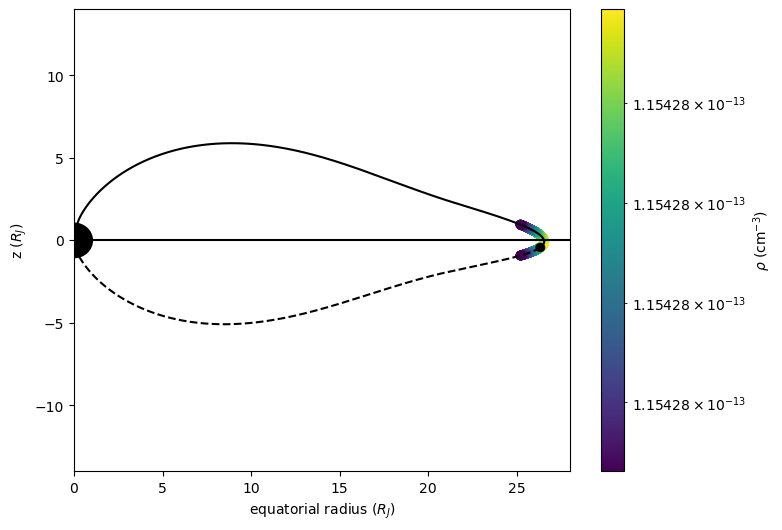

In [6]:
from plotting_functions import plot_MFL_and_rho_CS

# Centrifugal equator :
# Magnetic equator :
#H = 1.21*R_J
#rho_0_optimized = 3.12E-21 # km/m^3



z_lim_N = 0.96
H = 0.94*R_J
rho_0_optimized = 4.10E-21 # km/m^3


if jovicentric_equator:
        (x_N,y_N,z_N) = spherical_to_cartesian(r_N, theta_N, phi_N)
        (x_S,y_S,z_S) = spherical_to_cartesian(r_S, theta_S, phi_S)
else:
    if centrifugal_equator:
        theta_d = 9.3*1/3 # Centrifugal Equator tilt
    if magnetic_equator:
        theta_d = 9.3 
    phi_d = 204.2

    theta_N_transformed = 90-(theta_d*numpy.cos((phi_d-(360-phi_N))*numpy.pi/180.)+(90-theta_N))
    theta_S_transformed = 90-(theta_d*numpy.cos((phi_d-(360-phi_S))*numpy.pi/180.)+(90-theta_S))

(x_N,y_N,z_N) = spherical_to_cartesian(r_N, theta_N_transformed, phi_N)
(x_S,y_S,z_S) = spherical_to_cartesian(r_S, theta_S_transformed, phi_S)

equatorial_radius_N = numpy.sqrt(x_N**2 + y_N**2)
equatorial_radius_S = numpy.sqrt(x_S**2 + y_S**2)
mask_CS_N = (z_N <= z_lim_N*R_J) & (equatorial_radius_N > 10*R_J) # Second condition is to be sure no points close to the planet are taken
mask_CS_S = equatorial_radius_S >= equatorial_radius_N[mask_CS_N].min()


x_vals_CS = numpy.concatenate((x_N[mask_CS_N], x_S[mask_CS_S]))
y_vals_CS = numpy.concatenate((y_N[mask_CS_N], y_S[mask_CS_S]))
z_vals_CS = numpy.concatenate((z_N[mask_CS_N], z_S[mask_CS_S]))
equatorial_vals = numpy.concatenate((equatorial_radius_N[mask_CS_N], equatorial_radius_S[mask_CS_S]))

plot_MFL_and_rho_CS(x_N/R_J, y_N/R_J, z_N/R_J,
                        x_S/R_J, y_S/R_J, z_S/R_J,
                        mask_CS_N, mask_CS_S,
                        r_0, H, n_0_electrons[0][0], disk = False,
                        cb_title = r'$\rho$ (cm$^{-3}$)'
                        )


In [13]:
from magnetic_field_functions import length_magnetic_field_line

length_mfl_B_CS_N = length_magnetic_field_line(x_N[mask_CS_N],y_N[mask_CS_N],z_N[mask_CS_N], spherical = False, cartesian = True)
length_mfl_B_CS_S = length_magnetic_field_line(x_S[mask_CS_S],y_S[mask_CS_S],z_S[mask_CS_S], spherical = False, cartesian = True)

## Summary of the results

$\lambda_\mathrm{MAW~observed~in~UV}$: 297.70°

$\lambda_\mathrm{TEB~observed~in~UV}$: 303.05°

**CS aligned with magnetic equator**
| $\rho_0 (\mathrm{kg}/\mathrm{cm}^{3}$)| H = 0.75 | H=1.0      | H = 1.21  | H = 1.5   | H = 2.0   | H = 2.5   | H = 3.0   |
| ---                                   | ---      | ---        | ---       | ---       | ---       | ---       | ---       |
| E = 10 keV                            | 4.73E-21 | 3.70E-21   | 3.12E-21  | 3.34E-21  | 2.98E-21  | 2.92E-21  | 2.90E-21  |
| $\lambda_\mathrm{MAW}$ (°)            | 299.33   | 298.43     | 296.83    | 297.70    | 295.57    | 294.60    | 293.77    |
| $\lambda_\mathrm{TEB}$ (°)            | 304.68   | 303.78     | 302.18    | 303.05    | 300.92    | 299.95    | 299.12    |



**CS aligned with centrifugal equator**
| $\rho_0 (\mathrm{kg}/\mathrm{cm}^{3}$)| H = 0.75 | H=0.94      | H=1.0      | H = 1.5   | H = 2.0   | H = 3.0   |
| ---                                   | ---      | ---        | ---        | ---       | ---       | ---       |
| E = 10 keV                            | 4.37E-21 | 4.10E-21   | 4.04E-21   | 3.79E-21  | 3.69E-21  | 3.57E-21  |
| $\lambda_\mathrm{MAW}$ (°)            | 298.62   | 297.70     | 297.44     | 295.56    | 294.21    | 292.39    |
| $\lambda_\mathrm{TEB}$ (°)            | 303.97   | 303.05     | 302.79     | 300.91    | 299.56    | 297.73    |

 

(5.93E+07 m/s (E = 10.00 keV)
H: 0.94
ρ_0_optimized:  kg/m^3
λ (TEB) from UV measurement: 303.05
λ (MAW) from UV measurement: 297.70
Δλ observed: 5.35°
λ TEB: °, 
λ MAW: °
t TEB: 395.17 s, 
t MAW: 941.06, 
Δt: 545.90 s, 
Δλ: 5.35°
ρ @ Callisto: 2.6100998049923022e-27 kg / cm3